In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os

image_folder_path = 'RFMID2'
array_save_path = 'balanced_images_array.npy'

labels_df = pd.read_csv('newlabels.csv')
no_disease_indices = labels_df[(labels_df['DR'] == 0) & (labels_df['EDN'] == 0) & (labels_df['HR'] == 0)].index
keep_indices = np.random.choice(no_disease_indices, 200, replace=False)
disease_indices = labels_df.index.difference(no_disease_indices)
balanced_indices = np.concatenate([keep_indices, disease_indices])
balanced_labels_df = labels_df.loc[balanced_indices]
balanced_labels_df = balanced_labels_df.sample(frac=1, random_state=42)  
resized_images = []
labels = []

target_shape = (512, 512)

for _, row in balanced_labels_df.iterrows():
    image_id = row['ID']
    image_path = os.path.join(image_folder_path, f"{image_id}.jpg")
    try:
        with Image.open(image_path) as img:
            resized_img = img.resize(target_shape, Image.LANCZOS)
            resized_images.append(np.array(resized_img))
            labels.append(row[['DR', 'EDN', 'HR']].values)
    except IOError:
        print(f"Error opening or reading image {image_id}.jpg")

images_array = np.stack(resized_images)
labels_array = np.array(labels)

print(f"Number of images: {images_array.shape[0]}")
print(f"Number of label sets: {labels_array.shape[0]}")

np.save(array_save_path, images_array)


Error opening or reading image 151.jpg
Error opening or reading image 89.jpg
Number of images: 390
Number of label sets: 390


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

features = feature_extractor.predict(images_array)


13/13 [==============================] - 59s 4s/step


In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

labels_array = np.array(labels)  

model = Sequential([
    Dense(512, activation='relu', input_dim=features.shape[1]),
    Dense(256, activation='relu'),
    Dense(labels_array.shape[1], activation='sigmoid')  
])

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [5]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels_array, test_size=0.2, random_state=42)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=5,  
                               verbose=1,
                               mode='min',  
                               restore_best_weights=True)  
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping]) 

Epoch 1/100
10/10 [==============================] - 1s 57ms/step - loss: 3.0842 - accuracy: 0.1923 - val_loss: 0.9436 - val_accuracy: 0.5641
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 0.7187 - accuracy: 0.4167 - val_loss: 0.7508 - val_accuracy: 0.2179
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 0.3765 - accuracy: 0.3974 - val_loss: 0.4633 - val_accuracy: 0.3974
Epoch 4/100
10/10 [==============================] - 0s 21ms/step - loss: 0.3683 - accuracy: 0.3910 - val_loss: 0.4891 - val_accuracy: 0.4615
Epoch 5/100
10/10 [==============================] - 0s 22ms/step - loss: 0.3651 - accuracy: 0.4455 - val_loss: 0.3456 - val_accuracy: 0.4615
Epoch 6/100
10/10 [==============================] - 0s 19ms/step - loss: 0.2444 - accuracy: 0.5128 - val_loss: 0.6480 - val_accuracy: 0.2821
Epoch 7/100
10/10 [==============================] - 0s 18ms/step - loss: 0.2581 - accuracy: 0.4776 - val_loss: 0.3269 - val_accuracy: 0.5897
Epoch 

In [6]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_accuracy)


3/3 - 0s - loss: 0.3233 - accuracy: 0.5769 - 39ms/epoch - 13ms/step

Test accuracy: 0.5769230723381042


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

predictions = model.predict(X_test)

predictions_binary = (predictions > 0.5).astype(int)

accuracy = accuracy_score(y_test, predictions_binary)
print("Subset Accuracy: ", accuracy)

precision_macro = precision_score(y_test, predictions_binary, average='macro')
recall_macro = recall_score(y_test, predictions_binary, average='macro')
f1_macro = f1_score(y_test, predictions_binary, average='macro')

precision_micro = precision_score(y_test, predictions_binary, average='micro')
recall_micro = recall_score(y_test, predictions_binary, average='micro')
f1_micro = f1_score(y_test, predictions_binary, average='micro')

print("Precision (Macro): ", precision_macro)
print("Recall (Macro): ", recall_macro)
print("F1-Score (Macro): ", f1_macro)

print("Precision (Micro): ", precision_micro)
print("Recall (Micro): ", recall_micro)
print("F1-Score (Micro): ", f1_micro)

hamm_loss = hamming_loss(y_test, predictions_binary)
print("Hamming Loss: ", hamm_loss)

jaccard_macro = jaccard_score(y_test, predictions_binary, average='macro')
jaccard_micro = jaccard_score(y_test, predictions_binary, average='micro')

print("Jaccard Score (Macro): ", jaccard_macro)
print("Jaccard Score (Micro): ", jaccard_micro)

report = classification_report(y_test, predictions_binary, target_names=['DR', 'EDN', 'HR']) # Adjust label names
print(report)


3/3 [==============================] - 0s 4ms/step
Subset Accuracy:  0.6666666666666666
Precision (Macro):  0.8121212121212121
Recall (Macro):  0.5972222222222222
F1-Score (Macro):  0.6551495016611296
Precision (Micro):  0.7804878048780488
Recall (Micro):  0.6037735849056604
F1-Score (Micro):  0.6808510638297872
Hamming Loss:  0.1282051282051282
Jaccard Score (Macro):  0.5310175794455714
Jaccard Score (Micro):  0.5161290322580645
              precision    recall  f1-score   support

          DR       1.00      0.88      0.93        16
         EDN       0.64      0.67      0.65        21
          HR       0.80      0.25      0.38        16

   micro avg       0.78      0.60      0.68        53
   macro avg       0.81      0.60      0.66        53
weighted avg       0.80      0.60      0.65        53
 samples avg       0.37      0.35      0.35        53



C:\Users\Harshu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Harshu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


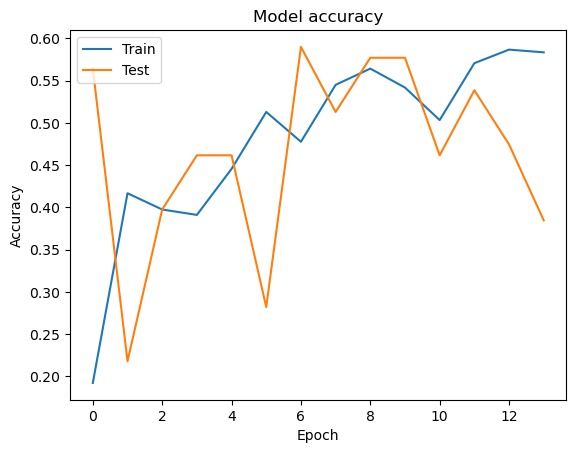

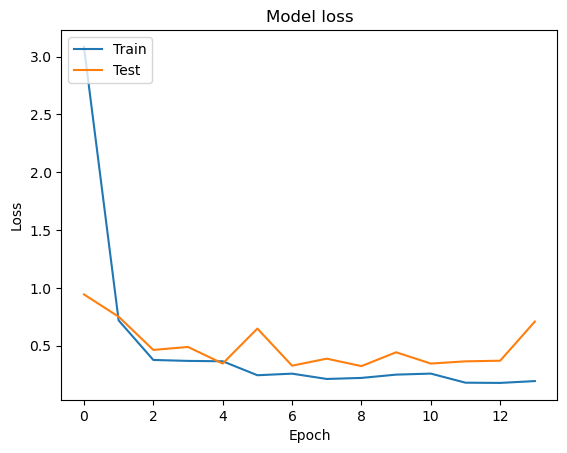

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
